In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

from density import density_profile, parker_critical, mach_parker
from ifront_guess import ionisation_front, ionisation_fraction_error, ionisation_fraction_plot, generate_guess_light, generate_guess_dense
from ifront_guess import scale_height, surface_density, light_or_dense

In [2]:
from astropy.constants import M_sun, R as R_gas, G
k = 1e-2 * u.cm**2/u.g # opacity
alpha_B = 2.6e-13 * (u.cm**3)/u.s # cm3s-1 at (T = 10^4 K) From Owen and Alvarez 2016

## Calculate mass loss rate
The mass loss rate can be found knowing the position of the ionisation front:
$$\dot M = 4\pi R_{IF}^2 c_s M(R_{IF}) \rho(R_{IF})$$

Where $\dot M$ is the mass loss, $R_{IF}$ the position of the ionisation front, $c_s$ the speed of sound, $M(R_{IF})$ the mach number at the ionisation front and $\rho(R_{IF})$ the density at the ionisation front.

In [3]:
def mass_loss_rate(r_I, R_s, M_s, a_H, a_P):
    R_I = r_I*parker_critical(a_P, M_s)
    rho_s = surface_density(a_H, M_s, R_s)
    rho = density_profile(r_I, r_I, R_s, M_s, rho_s, a_H, a_P)
    M_dot = 4*np.pi*(R_I**2)*a_P*mach_parker(r_I)*rho
    #print(a_P.decompose())
    #print(mach_parker(r_I))
    return M_dot

# Parameter List

In [4]:
# Parameter list
T_H = 3500 * u.K # temperature in hydrostatic region
T_P= 1e4 * u.K # temperature in parker wind region

mu_H = 1 * u.g / u.mol # mean molecular weight in units of hydrogen mass
mu_P = mu_H/2

M_s = 1*M_sun
M_BH = 4e6 * M_sun
R_s = 0.5 * u.astronomical_unit
d = 0.05 * u.parsec
a_H = np.sqrt(R_gas*T_H/mu_H)
a_P = np.sqrt(R_gas*T_P/mu_P)

rho_s = surface_density(a_H, M_s, R_s) # density at photosphere

In [5]:
# Find mass loss rate for single case
r_I = ionisation_front(0.5, M_s, M_BH, R_s, a_H, a_P, d)
print("Ionisation front squared:", (r_I*parker_critical(a_P, M_s).to(u.astronomical_unit))**2 )
print("Mach number:", mach_parker(r_I))
print("Density:", density_profile(r_I, r_I, R_s, M_s, rho_s, a_H, a_P).to("g/cm3"))
print("MLR:", mass_loss_rate(r_I, R_s, M_s, a_H, a_P).to(u.solMass/u.a))

/Users/jacopouggeri/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/jacopouggeri/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Ionisation front squared: 0.3363111350825263 AU2
Mach number: 0.009588049105157969
Density: 3.198777250988077e-14 g / cm3
MLR: 5.93671677476399e-09 solMass / a


# Mass loss rate as function of $r_I$

In [44]:
mlr = lambda r_I: mass_loss_rate(r_I, R_s, M_s, rho_s, a_H, a_P)

In [45]:
r_I = np.logspace(-2, 5, 100)

plt.loglog(r_I, mlr(r_I).to(u.astrophys.solMass/u.a))

plt.ylabel(r"$\dot M$")
plt.xlabel(r"$r_{IF}$")

TypeError: mass_loss_rate() takes 5 positional arguments but 6 were given

# Mass loss rate for increasing $\dot m$

In [10]:
m_dot = np.logspace(-3, 0, 10)

ig = lambda m_dot: ionisation_front(m_dot, M_s, M_BH, R_s, rho_s, a_H, a_P, d, verbose=False)
ig = np.vectorize(ig)
r_I = ig(m_dot)
mass_loss = mlr(r_I)


0.2 0.25 -0.0001 0.9998057450283911
0.2 0.25 -0.0001 0.9998057450283911
0.2 0.25 -0.0001 0.9998603659563076
0.2 0.25 -0.0001 0.9998818562515399
0.2 0.25 -0.0001 0.9998910476272727
0.2 0.25 -9.999999999999919e-05 0.9998952755767292
0.2 0.25 -9.999999999978886e-05 0.9998973516429004
0.2 0.25 -9.999999997371047e-05 0.9998984334736553
0.2 0.25 -9.999999826063601e-05 0.999899028615512
0.2 0.25 -9.999993343235648e-05 0.9998993723330909
0.2 0.25 -9.999841722017559e-05 0.9998995799763589


Text(0, 0.5, '$r_{IF}$')

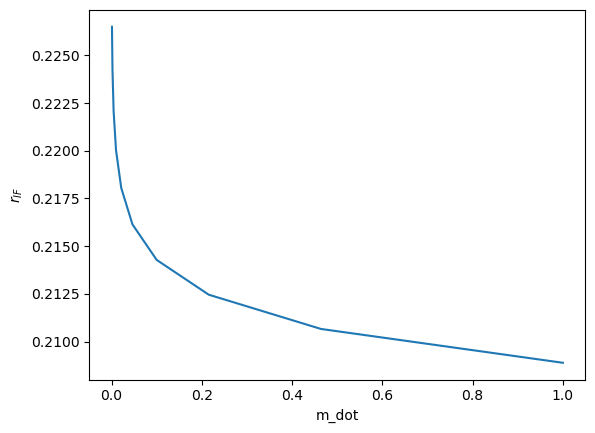

In [11]:
plt.plot(m_dot, r_I)
plt.xlabel("m_dot")
plt.ylabel(r"$r_{IF}$")

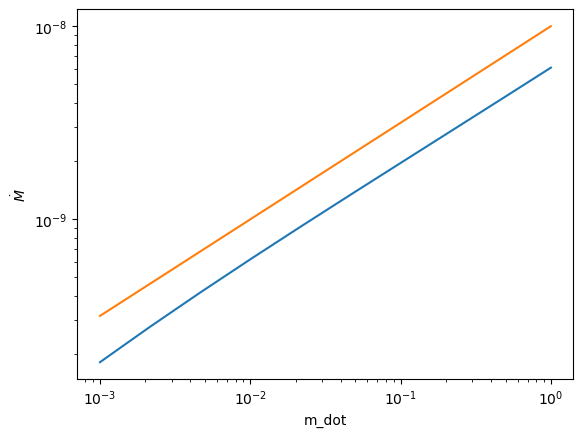

In [12]:
mass_loss = mass_loss.to(u.astrophys.solMass/u.a)
plt.plot(m_dot, mass_loss)
plt.xlabel("m_dot")
plt.ylabel(r"$\dot M$")
plt.xscale("log")
plt.yscale("log")
plt.plot(m_dot, np.sqrt(m_dot)*1e-8)

# Test parameter space:
## how do parameters affect ionisation front position?
Useful to find ionisation front guess for the root finding algorithm.

3 independent parameters:
- Flux: depends on black hole parameters and distance
    - $\frac{L_{edd}}{4\pi d^2} \propto \frac{M_{BH}}{d^2}$
- Mass of the star
- Radius of the star

Organise parameter gridsearch:
Use mass and radius in range of red giants:
$$0.5 M_\odot \leq M_s \leq 8 M_\odot$$
$$0.5 AU \leq R_s \leq 1 AU$$

Start by trying with a 10x10 grid

In [5]:
N = 15
m_dot_list = np.logspace(-1, 0, 3) 
mass_list = np.linspace(0.5, 8, N) * u.solMass
print(m_dot_list)

[0.1        0.31622777 1.        ]


Parametrise radius by escape velocity:
- Find minimum escape velocity(when model breaks down)
- Maximum radius is 1 AU

$v_e = \sqrt{\frac{2GM}{r}}$, so $r_{min} = \frac{2GM}{v_e^2}$

To have r array independent of M array, can use max value of mass to find the highest $r_{min}$


In [6]:
v_e_max = 92606 * u.m / u.s
radiai_list = np.zeros((N, N+1)) * u.astronomical_unit
for i, M_s in enumerate(mass_list):
    r_min = (2*G*M_s/(v_e_max**2)).to(u.astronomical_unit)
    #print(M_s, r_min.value)
    radiai_list[i, :] = np.linspace(r_min.value, 4, N+1) * u.astronomical_unit
#print(radiai_list)

### Test model step by step for different parameters

In [7]:
M_s, R_s = mass_list[3], radiai_list[3, 0]
m_dot = m_dot_list[0]
rho_s = surface_density(a_H, M_s, R_s)
print(M_s, R_s)

2.107142857142857 solMass 0.4359452463077387 AU


2.107142857142857 solMass 0.4359452463077387 AU
Scale height 0.0029585977307356928 AU
Critical point 5.620643314516264 AU
Density at r_I_guess 4.7019636860580675e-14 g / cm3
-2.7376572874079802e-05


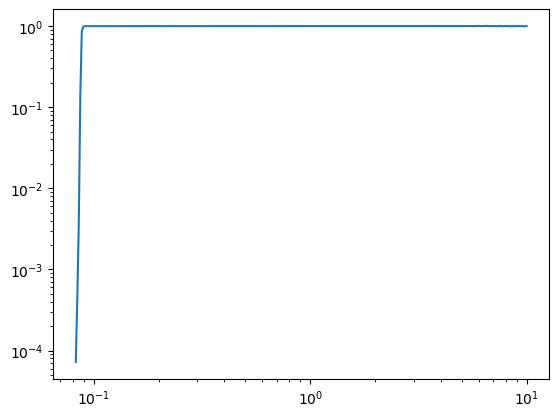

In [66]:
# Print values used and integrate
print(M_s.to("M_sun"), R_s)
print("Scale height", scale_height(a_H, M_s, R_s).to(u.astronomical_unit))
print("Critical point", parker_critical(a_P, M_s).to(u.astronomical_unit))
r_I_guess = 0.08262919698105857
print("Density at r_I_guess", density_profile(r_I_guess, r_I_guess, R_s, M_s, rho_s, a_H, a_P).to("g/cm3"))
print(ionisation_fraction_error(r_I_guess, M_s, M_BH, m_dot, R_s, a_H, a_P, d, R_bins=300))
x, y = ionisation_fraction_plot(r_I_guess, M_s, M_BH, m_dot, R_s, a_H, a_P, d, R_bins=300)
plt.loglog(x, y)

In [74]:
# Evaluate error function over range
r_size = 10
rguess = np.linspace(0.01, r_size/50, 100)
err = []
for r_I_guess in rguess:
    err.append(ionisation_fraction_error(r_I_guess, M_s, M_BH, m_dot, R_s, a_H, a_P, d, R_bins=300, r_size=r_size))

(0.0, 0.3)

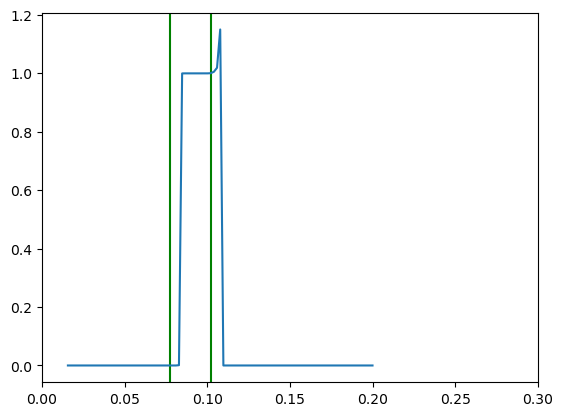

In [75]:
# Plot error function to diagnose problems with solver
if light_or_dense(M_s, R_s):       
    a, b = generate_guess_dense((M_s, M_BH, m_dot, R_s, a_H, a_P, d))
else:
    a, b = generate_guess_light((M_s, M_BH, m_dot, R_s, a_H, a_P, d))
plt.axvline(a, color="green")
plt.axvline(b, color="green")
plt.plot(rguess, err)
plt.xlim(0, 0.3)

In [70]:
# Find mass loss rate for single case
r_I = ionisation_front(m_dot, M_s, M_BH, R_s, a_H, a_P, d, R_bins = 300, debug=True)
print(r_I)
#print("Ionisation front:", r_I*parker_critical(a_P, M_s).to(u.astronomical_unit) )
#print("Mach number:", mach_parker(r_I))
print("MLR:", mass_loss_rate(r_I, R_s, M_s, a_H, a_P).to(u.solMass/u.a))

dense 0.10256145016031104 0.07756145016031103
(0.08262919698105857,       converged: True
           flag: 'converged'
 function_calls: 18
     iterations: 17
           root: 0.08262919698105857)
0.08262919698105857
MLR: 1.1789480676946226e-14 solMass / a


# Evaluate over grid

In [9]:
# Calculate ioniastion front for grid
r_I_list = np.zeros((len(mass_list), len(radiai_list[0, :]), len(m_dot_list)))
print(r_I_list.shape)
for i, M_s in enumerate(mass_list):
    for j, R_s in enumerate(radiai_list[i, :]):
        for k, m_dot in enumerate(m_dot_list):
            try:
                if i == 0: # Handle first row going beyond r = 10
                    res = ionisation_front(m_dot, M_s, M_BH, R_s, a_H, a_P, d, R_bins = 300, r_size = 50)
                else:
                    res = ionisation_front(m_dot, M_s, M_BH, R_s, a_H, a_P, d, R_bins = 300)
                r_I_list[i, j, k] = res
                print("* ", i, j, k, res, mass_list[i], radiai_list[i, j], m_dot_list[k])
            except ValueError as v:
                print("- ValueError: ", v)
                print("- ", i, j, k, "Fail", mass_list[i], radiai_list[i, j], m_dot_list[k])

(15, 16, 3)


/Users/jacopouggeri/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/jacopouggeri/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


*  0 0 0 0.08289758351861448 0.5 solMass 0.10344463471709053 AU 0.1
*  0 0 1 0.08247986853459015 0.5 solMass 0.10344463471709053 AU 0.31622776601683794
*  0 0 2 0.08206869315289356 0.5 solMass 0.10344463471709053 AU 1.0
*  0 1 0 0.3536830961183706 0.5 solMass 0.36321499240261784 AU 0.1
*  0 1 1 0.3461631135811296 0.5 solMass 0.36321499240261784 AU 0.31622776601683794
*  0 1 2 0.3389506117315471 0.5 solMass 0.36321499240261784 AU 1.0
*  0 2 0 0.7473313831214057 0.5 solMass 0.6229853500881452 AU 0.1
*  0 2 1 0.7163929476001873 0.5 solMass 0.6229853500881452 AU 0.31622776601683794
*  0 2 2 0.6877779172046995 0.5 solMass 0.6229853500881452 AU 1.0
*  0 3 0 1.298315071747456 0.5 solMass 0.8827557077736725 AU 0.1
*  0 3 1 1.2107345627290573 0.5 solMass 0.8827557077736725 AU 0.31622776601683794
*  0 3 2 1.1339101646730267 0.5 solMass 0.8827557077736725 AU 1.0
*  0 4 0 2.1068021566821655 0.5 solMass 1.1425260654591998 AU 0.1
*  0 4 1 1.8872516870261604 0.5 solMass 1.1425260654591998 AU 0.316227

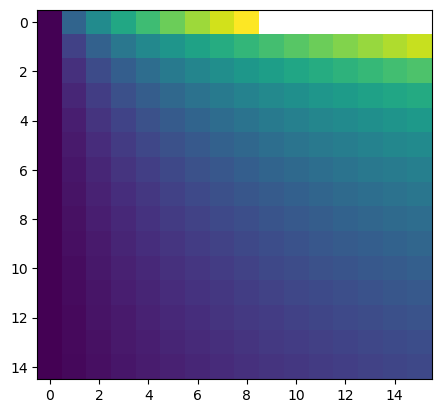

In [10]:
# Plot grid r_I values
plt.imshow(np.log10(r_I_list[:,:,-1]))

In [76]:
print(r_I_list[3, 0, 0])

0.018617333741584505


In [11]:
# Find mass loss rate over grid
m_loss_list = np.zeros((len(mass_list), len(radiai_list[0, :]), len(m_dot_list))) * u.solMass/u.a
for i, M_s in enumerate(mass_list):
    for j, R_s in enumerate(radiai_list[i, :]):
        for k, m_dot in enumerate(m_dot_list):
            r_I = r_I_list[i, j, k]
            M_dot = mass_loss_rate(r_I, R_s, M_s, a_H, a_P).decompose()
            m_loss_list[i, j, k] = M_dot.to(u.solMass/u.a)

/Users/jacopouggeri/Library/CloudStorage/OneDrive-ImperialCollegeLondon/MSci Project-MacBook Pro di Jacopo/Code/density.py:44: RuntimeWarning: invalid value encountered in double_scalars
  arg = -(ratio)**4 * np.exp(3 - 4*ratio)
/Users/jacopouggeri/Library/CloudStorage/OneDrive-ImperialCollegeLondon/MSci Project-MacBook Pro di Jacopo/Code/density.py:87: RuntimeWarning: invalid value encountered in double_scalars
  return ((r_I/r)**2) * rho_p * m_ratio


In [69]:
print(m_loss_list[3, 0, 0])

2.8823801403617752e+156 solMass / a


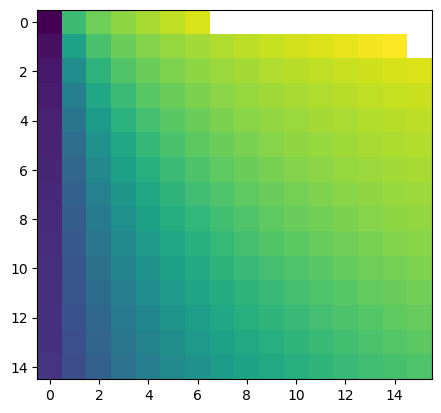

In [12]:
plt.imshow(np.log10(m_loss_list[:,:,0].value))

Text(0, 0.5, 'Radius (AU)')

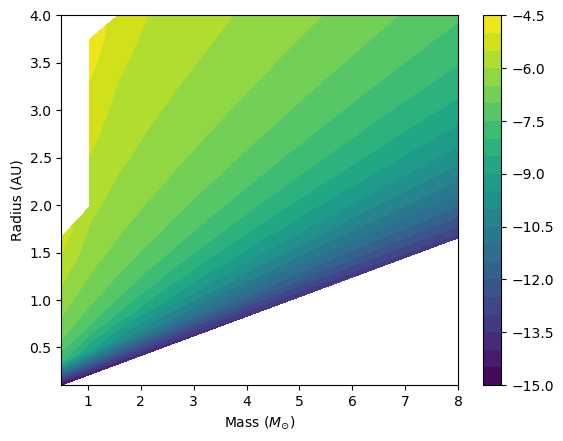

In [15]:
from matplotlib import cm, colors, ticker
X = np.tensordot(mass_list, np.ones(N + 1), axes=0).value
Y = radiai_list.to(u.astronomical_unit).value
Z = m_loss_list[:, :, 0].to(u.solMass/u.a).value

plt.contourf(X, Y, np.log10(Z), 20)
#plt.scatter(X, Y)
plt.colorbar()

plt.xlabel(r"Mass $(M_{\odot}$)")
plt.ylabel("Radius (AU)")
#print(X, radiai_list)

In [31]:
print(np.nanmin(m_loss_list))

1.9334352656643094e-15 solMass / a


In [32]:
# Find mass loss rate over grid
v_esc_list = np.zeros((len(mass_list), len(radiai_list[:, 0]), len(m_dot_list))) * u.m/u.s
for i, M_s in enumerate(mass_list):
    for j, R_s in enumerate(radiai_list[:, i]):
        v_esc_list[i, j] = np.sqrt(2*G*M_s/R_s).decompose()

[[[92606.        ]
  [46303.        ]
  [35001.77798749]
  [29284.58849976]
  [25684.28318582]
  [23151.5       ]]

 [[68653.54353173]
  [59230.30956891]
  [52857.3304412 ]
  [48179.38172904]
  [44557.65521526]
  [41646.44012702]]

 [[66546.04017314]
  [62121.08746738]
  [58475.67525017]
  [55404.88132985]
  [52772.05001301]
  [50482.08548198]]

 [[65755.76273762]
  [63401.98272633]
  [61284.12585171]
  [59365.24307347]
  [57616.01031666]
  [56012.81777066]]

 [[65341.72264729]
  [64125.3688463 ]
  [62974.50859329]
  [61883.46786149]
  [60847.23780144]
  [59861.37772607]]

 [[65086.88519655]
  [64590.25929758]
  [64104.83069404]
  [63630.18484228]
  [63165.92837133]
  [62711.68771245]]] m / s


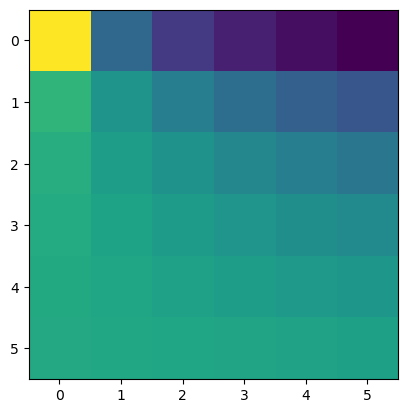

In [31]:
plt.imshow(v_esc_list)
print(v_esc_list)

In [32]:
pos = np.where(m_loss_list == np.nanmin(m_loss_list[:10,:]))
mass_min = mass_list[pos[0]]
radius_min = radiai_list[pos[1]]
print(pos, mass_min, radius_min)
print(np.sqrt(2*G*mass_min/radius_min).decompose())

(array([0]), array([0]), array([0])) [0.5] solMass [[0.10344463 0.75287053 1.40229642 2.05172232 2.70114821 3.35057411
  4.        ]] AU
[[92606.         34326.77176586 25152.03900489 20793.79795325
  18122.53318707 16271.72129914 14892.34591484]] m / s


In [16]:
import os
def new_fname(name, path="data", form="txt"):
    """Generate file name not present in the directory from given string.

    Parameters
    ----------
    name : str
        proposed file name
    path : str, optional
        directory in which the file will be saved, use empty string for current directory, by default "data"
    form : str, optional
        format of file, eg. "txt" or "npy"
    """
    # Folder path where the files are located
    folder_path = "data"

    # Desired file name
    file_name = name
    current_file_name = file_name + "." + form
    current_file_path = os.path.join(folder_path, current_file_name)

    # Initialize the file number
    file_num = 1

    # Check if file name already exists in the folder
    while True:
        current_file_name = file_name + str(file_num) + "." + form
        current_file_path = os.path.join(folder_path, current_file_name)
        if os.path.exists(current_file_path):
            file_num += 1
        else:
            break

    return current_file_path

In [17]:
# Save data in files
np.savetxt(new_fname("mass_list"), mass_list.to(u.solMass).value) # In solar masses
np.savetxt(new_fname("radiai_list"), radiai_list.to(u.astronomical_unit).value) # In astronomical units
np.savetxt(new_fname("m_dot_list"), m_dot_list)
# 3D arrays in npy format
np.save(new_fname("r_I_list", form="npy"), r_I_list)
np.save(new_fname("m_loss_list", form="npy"), m_loss_list.to(u.solMass/u.a).value) # In solar masses per year



In [18]:
params = {
    'T_H': T_H,
    'T_P': T_P,
    'mu_H': mu_H,
    'mu_P': mu_P,
    'M_BH': M_BH,
    'd': d
}
print(params)
np.save(new_fname("params", form="npy"), params)

{'T_H': <Quantity 3500. K>, 'T_P': <Quantity 10000. K>, 'mu_H': <Quantity 1. g / mol>, 'mu_P': <Quantity 0.5 g / mol>, 'M_BH': <Quantity 7.95363948e+36 kg>, 'd': <Quantity 0.05 pc>}


### Resolution check
Radial bins for integration go up to $10R_c$, check that bin number contain at least 3 bins per scale height

In [78]:
R_bins = 300
arr = np.zeros((len(mass_list), len(radiai_list)))

for i, M_s in enumerate(mass_list):
    R_c = parker_critical(a_P, M_s)
    for j, R_s in enumerate(radiai_list):
        H = a_P**2/(G*M_s/R_s**2) # scale height
        arr[i, j] = R_c/R_bins < H

plt.imshow(arr)

ValueError: setting an array element with a sequence.

In [134]:
# Find necessary bin sizes
bin_sizes = []
for i, M_s in enumerate(mass_list):
    R_c = parker_critical(a_P, M_s)
    for j, R_s in enumerate(radiai_list):
        H = a_P**2/(G*M_s/R_s**2) # scale height
        bin_sizes.append()
        print(M_s, R_s, 10*R_c/R_bins > H)

TypeError: list.append() takes exactly one argument (0 given)